# Praktyczne Uczenie Maszynowe - Projekt

Dobrać minimalny (pod względem złożoności czasowej, pamięciowej, implementacyjnej) klasyfikator dla zbioru Iris o skuteczności > 95%

## Importowanie potrzebnych bibliotek

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from time import perf_counter
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

## Załadowanie zbioru danych

In [2]:
iris = load_iris()
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_df['species'] = pd.Categorical.from_codes(iris.target, iris.target_names)

## Analiza zbioru danych

### Podstawowe informacje



Zbiór danych Iris zawiera 150 obserwacji, z których każda reprezentuje poszczególny kwiat irysa. Dane te są szczegółowo opisane za pomocą czterech cech dotyczących wymiarów kwiatów, podanych w centymetrach:

* Długość działki kielicha (sepal length)
* Szerokość działki kielicha (sepal width)
* Długość płatka (petal length)
* Szerokość płatka (petal width)

Dodatkowo, zbiór danych obejmuje informacje o gatunku każdego irysa.

In [3]:
display(iris_df)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


Zbiór danych składa się z pięciu kolumn, gdzie cztery z nich to zmienne numeryczne typu float64. Piąta kolumna (species) to zmienna kategoryczna. W zbiorze nie ma brakujących wartości.

In [4]:
iris_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   sepal length (cm)  150 non-null    float64 
 1   sepal width (cm)   150 non-null    float64 
 2   petal length (cm)  150 non-null    float64 
 3   petal width (cm)   150 non-null    float64 
 4   species            150 non-null    category
dtypes: category(1), float64(4)
memory usage: 5.1 KB


Zbiór zawiera dane na temat trzech gatunków irysów:
* Iris setosa
* Iris versicolor
* Iris virginica

Każdy gatunek jest reprezentowany przez 50 próbek.

In [5]:
iris_df['species'].value_counts()

setosa        50
versicolor    50
virginica     50
Name: species, dtype: int64

### Analiza eksploracyjna danych (Exploratory Data Analysis, EDA)

#### Podstawowe statystyki

In [6]:
iris_df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


Długość działki kielicha ma najwyższą średnią wartość (5.84 cm) oraz stosunkowo umiarkowaną zmienność, o czym świadczy odchylenie standardowe równe 0.83.

Niskie odchylenie standardowe równe 0.44 cm dla szerokości działki wskazuje na małą zmienność danych. Rozstęp międzykwartylowy jest wąski (od 2.8 do 3.3 cm), co oznacza, że większość danych skupia się wokół mediany 3.0 cm.

Długość płatka ma największe odchylenie standardowe (1.77 cm), co wskazuje na dużą zmienność tej cechy oraz najszerszy zakres (1.0 - 6.9 cm). Być może odzwierciedla to różnice między gatunkami irysów.

Szerokość płatka charakteryzuje się najmniejszą średnią wartością (1.20 cm). Wartości kwartyli swiądczą o tym, że większość płatków ma szerokość między 0.3 a 1.8 cm, z mediana lekko przesuniętą ku wyższym wartościom.

#### Rozkłady danych

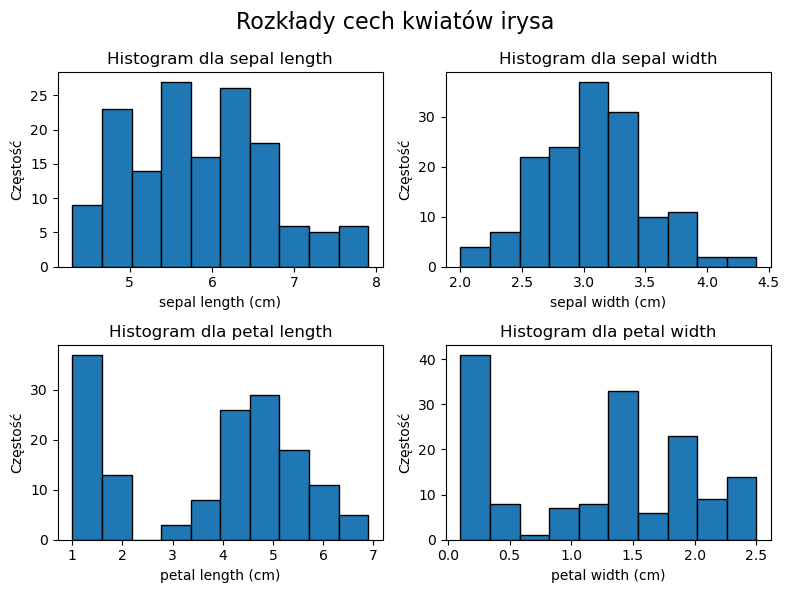

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))
axes = axes.ravel()

columns = iris_df.columns

for ax, col in zip(axes, columns):
    ax.hist(iris_df[col], bins=10, edgecolor='black')
    ax.set_title(f'Histogram dla {col[:-5]}')
    ax.set_xlabel(f'{col}')
    ax.set_ylabel('Częstość')
plt.suptitle('Rozkłady cech kwiatów irysa', fontsize=16)
plt.tight_layout()
plt.show()

Rozkład długości działki zbliża się do normalnego, ale z lekkim przesunięciem w lewo. Rozkład jest stosunkowo równomierny w zakresie od 4.5 cm do 7 cm, ale wykazuje kilka szczytów, z największym w okolicach 5.5 cm. Wykres sugeruje, że jest to cecha stosunkowo jednorodna wśród irysów.

Szerokość działki charakteryzuje się bardziej wąskim rozkładem zbliżonym do normalnego z wyraźnym szczytem w 3 cm. Rozkład wydaje się być bardziej symetryczny niż dla długości płatków. Na histogramie można zauważyć kilka wartości odstających, szczególnie w kierunku wyższych wartości.

Histogram długości płatka pokazuje wyraźnie bimodalny rozkład, z jednym szczytem poniżej 2 cm, a drugim w okolicach 4.5 cm. To sugeruje, że istnieją dwie grupy irysów z znacznie różnymi długościami płatków, co może odpowiadać różnym gatunkom irysów.

Szerokość płatka również wykazuje bimodalność, z większością obserwacji poniżej 0.5 cm oraz w zakresie 1.5-2.5 cm. To również sugeruje istnienie dwóch grup irysów o różnych cechach morfologicznych płatków.


#### Wykresy pudełkowe

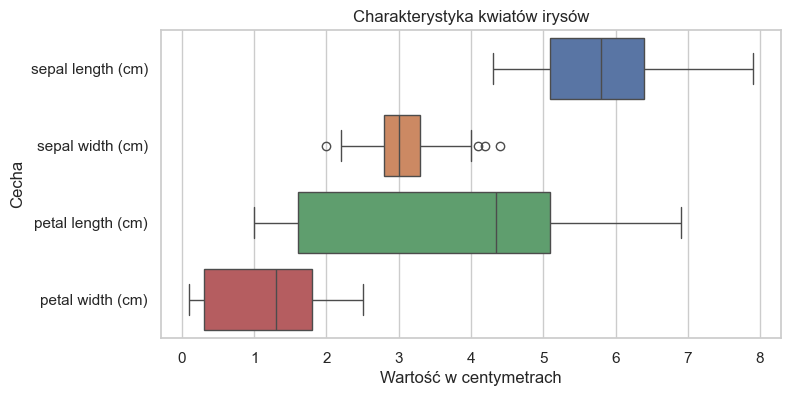

In [8]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 4))
sns.boxplot(data=iris_df, orient="h")
plt.title("Charakterystyka kwiatów irysów")
plt.xlabel("Wartość w centymetrach")
plt.ylabel("Cecha")
plt.show()

Długość działki kielicha irysów ma medianę około 6 cm. Niewiele wartości odstających wskazuje na jednorodność tej cechy w populacji irysów.

Szerokość działki kielicha ma wartości, z medianą około 3 cm i wartościami rozciągającymi się od 2 cm do 4.5 cm. Obecność wartości odstających może sugerować, że niektóre irysy mają szczególnie szerokie lub wąskie działki.

Długość płatków jest cechą najbardziej zróżnicowaną, z wyraźnie dłuższym zakresem wartości. Rozkład wartości jest przesunięty ku wyższym wartościom z medianą powyżej 4 cm.

Szerokość płatków irysów ma najmniejszy zakres wśród badanych cech.

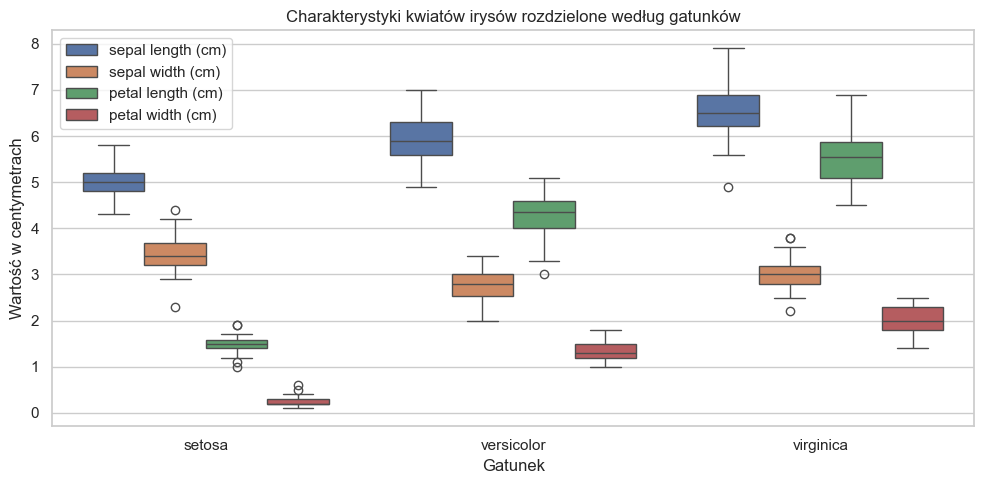

In [9]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 5))
sns.boxplot(x='species', y='value', hue='variable', data=pd.melt(iris_df, id_vars='species'))
plt.title('Charakterystyki kwiatów irysów rozdzielone według gatunków')
plt.xlabel('Gatunek')
plt.ylabel('Wartość w centymetrach')
plt.legend()
plt.tight_layout()
plt.show()

Setosa:
* Średnie wartości długości działki są najniższe spośród gatunków, co wskazuje na mniejsze rozmiary działek w tym gatunku.
* Szerokość działki o stosunkowo szerokim rozkładzie z wartościami odstającymi po obu stronach sugeruje zmienność tej cechy w obrębie gatunku.
* Długość płatka i szerokość płatka mają bardzo niskie wartości z niewielkim zakresem zmienności, co charakteryzuje Setosę jako gatunek z małymi płatkami.

Iris Versicolor:
* Wartości długości działki oraz długości i szerokości płatka są pośrednie między Setosą a Virginicą, co może wskazywać na pośredni rozmiar roślin w tym gatunku.
* Rozkład szerokości działki jest węższy niż u Setosy, z mniejszą liczbą wartości odstających.

Iris Virginica:
* Posiada najwyższe wartości długości działki oraz długości i szerokości płatka, co wskazuje na to, że Virginica ma generalnie większe działki oraz płatki niż pozostałe gatunki.
* Chociaż rozkład szerokości działki jest podobny do Versicolor, to wartości odstające po stronie wyższej sugerują większą zmienność.

#### Relacje między cechami

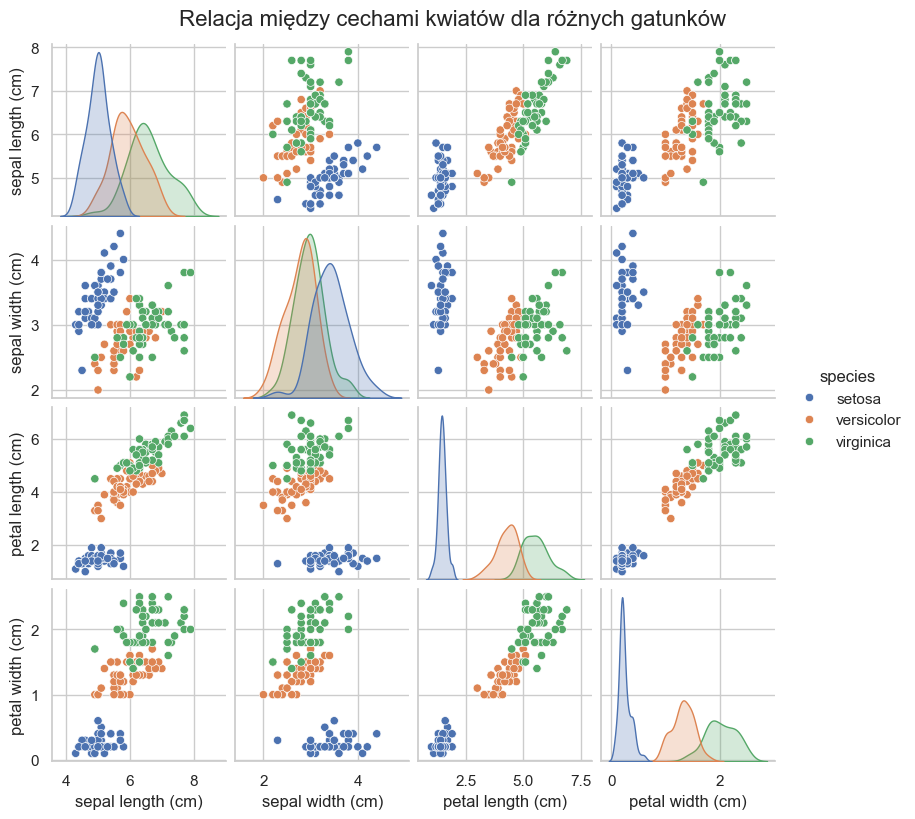

In [10]:
sns.pairplot(iris_df, hue="species", height=2)
plt.suptitle('Relacja między cechami kwiatów dla różnych gatunków', size=16, y=1.02)
plt.show()

Istnieje silna korelacja między długością działki a długością płatka dla gatunków Versicolor i Virginica. W przypadku Setosa ta korelacja nie jest tak wyraźna. Korelacje między szerokością działki a szerokością płatka są mniej wyraźne, jednakże dla Versicolor i Virginica obserwujemy umiarkowaną zależność. Setosa ma tendencję do posiadania szerokich działek i wąskich płatków.

Na wykresach rozrzutu każdy gatunek irysów tworzy wyraźnie odseparowane grupy, co wskazuje na istotne różnice morfologiczne między nimi. Iris Setosa zazwyczaj grupuje się oddzielnie od Versicolor i Virginica we wszystkich kombinacjach cech. Virginica i Versicolor często wykazują pewne nakładanie się, ale nadal można rozróżnić te dwa gatunki na podstawie kombinacji cech, takich jak długość płatka i długość działki, gdzie Virginica zazwyczaj wykazuje większe wartości.

W rozkładzie długości działki, Setosa wykazuje wąski i niski rozkład z mniejszymi wartościami, Versicolor ma bardziej rozproszony i symetryczny rozkład, a Virginica prezentuje najszerszy zakres z najwyższymi wartościami. W przypadku szerokości działki, Setosa ma szersze działki z większą zmiennością, podczas gdy Versicolor i Virginica mają bardziej skoncentrowane rozkłady wokół średnich wartości. Długość płatka dla Setosa jest niska, Versicolor ma wartości pośrednie, a Virginica wykazuje najwyższe wartości. Szerokość płatka jest najmniejsza dla Setosa, pośrednia dla Versicolor i największa dla Virginica.

#### Macierz korelacji

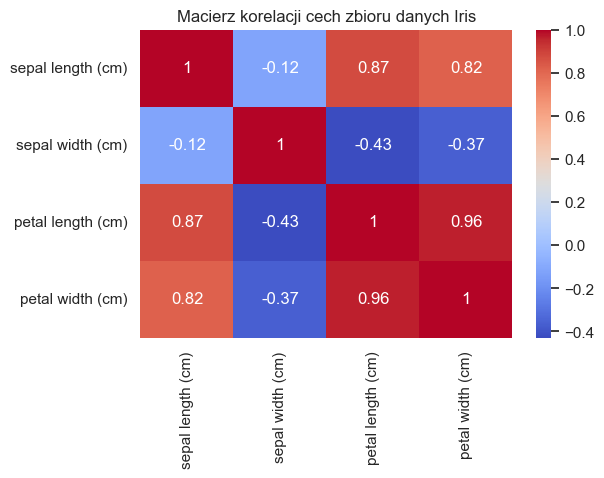

In [11]:
plt.figure(figsize=(6, 4))
sns.heatmap(iris_df.select_dtypes(exclude=['category']).corr(), annot=True, cmap='coolwarm')
plt.title('Macierz korelacji cech zbioru danych Iris')
plt.show()

Bardzo silna dodatnia korelacja między długością płatka a szerokością płatka (0.96) wskazuje, że większe płatki są zazwyczaj zarówno dłuższe, jak i szersze.

Silne dodatnie korelacje między długością działki a długością płatka (0.87) oraz szerokością płatka (0.82) sugerują, że rośliny z większymi działkami mają również większe płatki.

Słaba korelacja szerokości działki z innymi cechami (długość działki -0.12, długość płatka -0.43, szerokość płatka -0.37) sugeruje, że szerokość działki jest stosunkowo niezależna od pozostałych cech.

### Analiza wartości odstających

Wartości odstające, zwane również outlierami to obserwacje, które znacząco odbiegają od pozostałych danych w zbiorze. Mogą one wpływać na wyniki analiz statystycznych i modelowania, dlatego ich identyfikacja i analiza jest kluczowa w procesie eksploracji danych.

#### Metoda IQR (Interquartile Range)

IQR to różnica między trzecim (Q3) a pierwszym (Q1) kwartylem zestawu danych. Jest to miara rozproszenia danych, która koncentruje się na środkowych 50% danych.

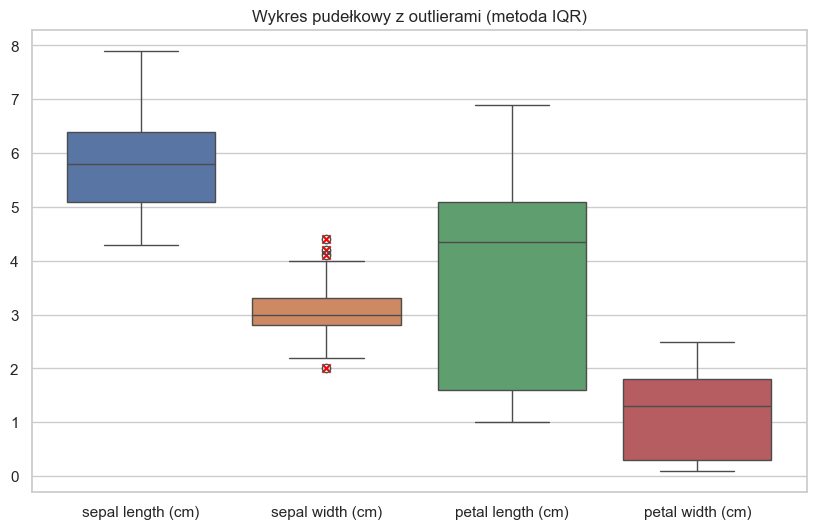

In [12]:
def calc_iqr(data):
  q1 = data.quantile(0.25)
  q3 = data.quantile(0.75)
  iqr = q3 - q1
  return (data < (q1 - 1.5 * iqr)) | (data > (q3 + 1.5 * iqr))

num_df = iris_df.select_dtypes(exclude=['category'])
outliers_iqr = calc_iqr(num_df)

plt.figure(figsize=(10, 6))
sns.boxplot(data=iris_df)
plt.title('Wykres pudełkowy z outlierami (metoda IQR)')
for i, column in enumerate(num_df.columns):
    outlier_points = num_df[column][outliers_iqr[column]]
    plt.scatter([i] * len(outlier_points), outlier_points, color='red', marker='x')
plt.show()

Wartości odstające występują wyłącznie w przypadku szerokości działki kielicha. Pozostałe cechy wykazują jednolity rozkład bez wartości odstających.

In [13]:
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

outliers_iqr_df_list = []
for column in num_df.columns:
    outliers_iqr_df_list.append(detect_outliers_iqr(iris_df, column))

outliers_iqr_df = pd.concat(outliers_iqr_df_list).drop_duplicates()

outliers_iqr_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
15,5.7,4.4,1.5,0.4,setosa
32,5.2,4.1,1.5,0.1,setosa
33,5.5,4.2,1.4,0.2,setosa
60,5.0,2.0,3.5,1.0,versicolor


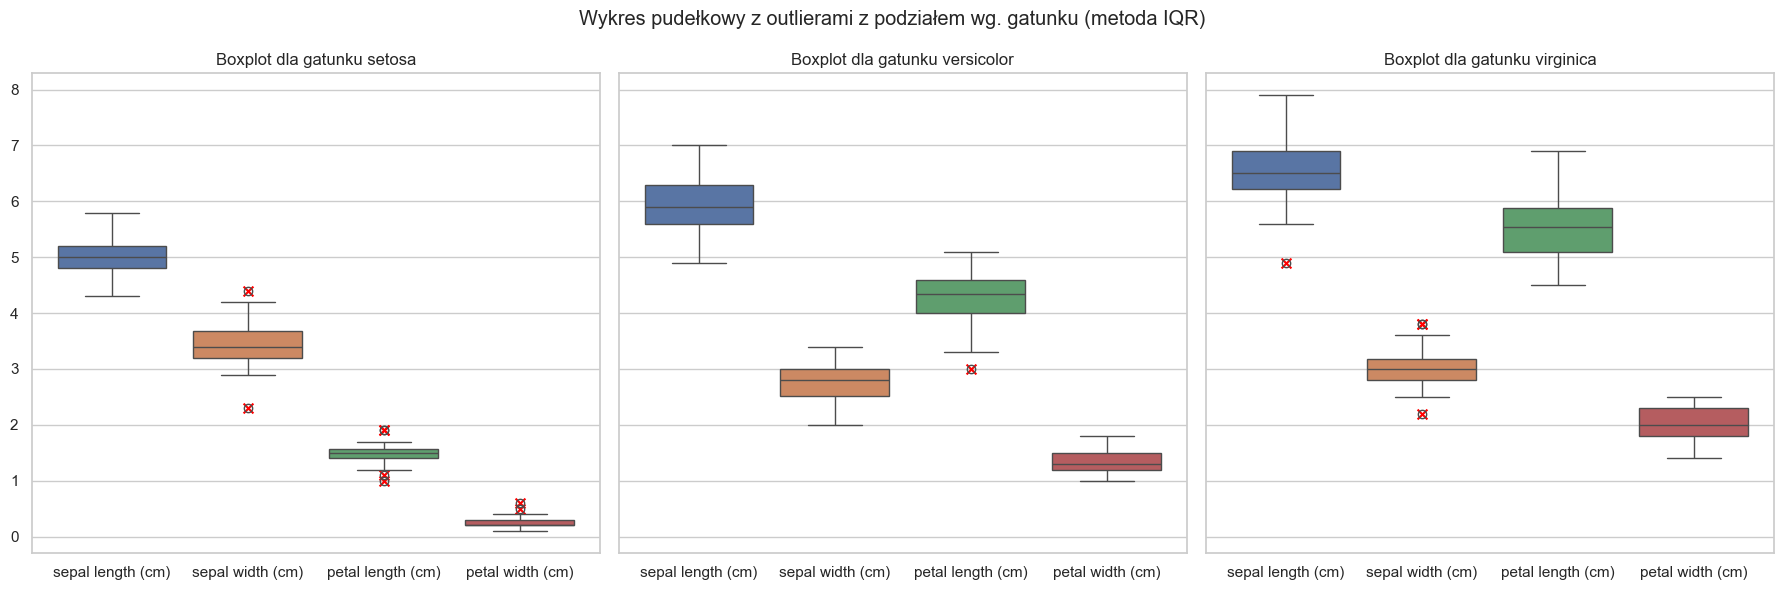

In [14]:
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

outliers = {}
for species in iris_df['species'].unique():
    outliers[species] = {}
    for column in iris_df.columns[:-1]:
        outliers[species][column] = detect_outliers_iqr(iris_df[iris_df['species'] == species], column)

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, species in enumerate(iris_df['species'].unique()):
    sns.boxplot(data=iris_df[iris_df['species'] == species].drop(columns=['species']), ax=axes[i])
    axes[i].set_title(f'Boxplot dla gatunku {species}')

    for j, column in enumerate(iris_df.columns[:-1]):
        outlier_points = outliers[species][column]
        axes[i].scatter([j]*len(outlier_points), outlier_points[column], color='red', s=50, marker='x')
fig.suptitle('Wykres pudełkowy z outlierami z podziałem wg. gatunku (metoda IQR)')

plt.tight_layout()
plt.show()

Wartości odstające są obecne w różnych cechach dla każdego gatunku, szczególnie w szerokości działki kielicha i szerokości płatka. Gatunek Setosa wykazuje więcej wartości odstających niż pozostałe dwa gatunki.

In [15]:
outliers_df_list = []
for species in iris_df['species'].unique():
    for column in iris_df.columns[:-1]:
        outliers_df_list.append(detect_outliers_iqr(iris_df[iris_df['species'] == species], column))

outliers_df = pd.concat(outliers_df_list).drop_duplicates()
print(outliers_df.shape[0])
display(outliers_df)

13


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
15,5.7,4.4,1.5,0.4,setosa
41,4.5,2.3,1.3,0.3,setosa
13,4.3,3.0,1.1,0.1,setosa
22,4.6,3.6,1.0,0.2,setosa
24,4.8,3.4,1.9,0.2,setosa
44,5.1,3.8,1.9,0.4,setosa
23,5.1,3.3,1.7,0.5,setosa
43,5.0,3.5,1.6,0.6,setosa
98,5.1,2.5,3.0,1.1,versicolor
106,4.9,2.5,4.5,1.7,virginica


#### Metoda MAD (Median Absolute Deviation)

MAD to mediana absolutnych odchyleń od mediany zestawu danych. Jest to miara rozproszenia danych, która jest oparta na medianie, a nie na średniej.

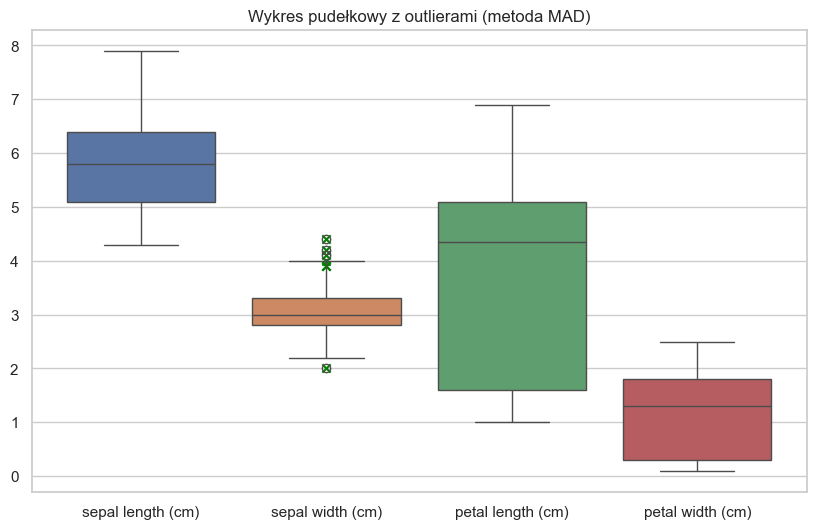

In [16]:
def mad(data, treshold=3):
    d = np.abs(data - np.median(data))
    t = treshold * np.median(d)
    return d > t

outliers_mad = num_df.apply(mad)

plt.figure(figsize=(10, 6))
sns.boxplot(data=iris_df)
plt.title('Wykres pudełkowy z outlierami (metoda MAD)')
for i, column in enumerate(num_df.columns):
    outlier_points = num_df[column][outliers_mad[column]]
    plt.scatter([i] * len(outlier_points), outlier_points, color='green', marker='x')
plt.show()

Podsumowując, metoda MAD wykazała, że wartości odstające występują głównie w szerokości działki kielicha. Pozostałe cechy, takie jak długość działki kielicha, długość płatka i szerokość płatka, nie wykazują istotnych odstających wartości, co sugeruje, że są one bardziej jednorodne.

In [17]:
def detect_outliers_mad(data, column, threshold=3):
    median = data[column].median()
    mad = np.median(np.abs(data[column] - median))
    lower_bound = median - threshold * mad
    upper_bound = median + threshold * mad
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

outliers_mad_df_list = []
for column in num_df.columns:
    outliers_mad_df_list.append(detect_outliers_mad(iris_df, column))

outliers_mad_df = pd.concat(outliers_mad_df_list).drop_duplicates()

outliers_mad_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
5,5.4,3.9,1.7,0.4,setosa
14,5.8,4.0,1.2,0.2,setosa
15,5.7,4.4,1.5,0.4,setosa
16,5.4,3.9,1.3,0.4,setosa
32,5.2,4.1,1.5,0.1,setosa
33,5.5,4.2,1.4,0.2,setosa
60,5.0,2.0,3.5,1.0,versicolor


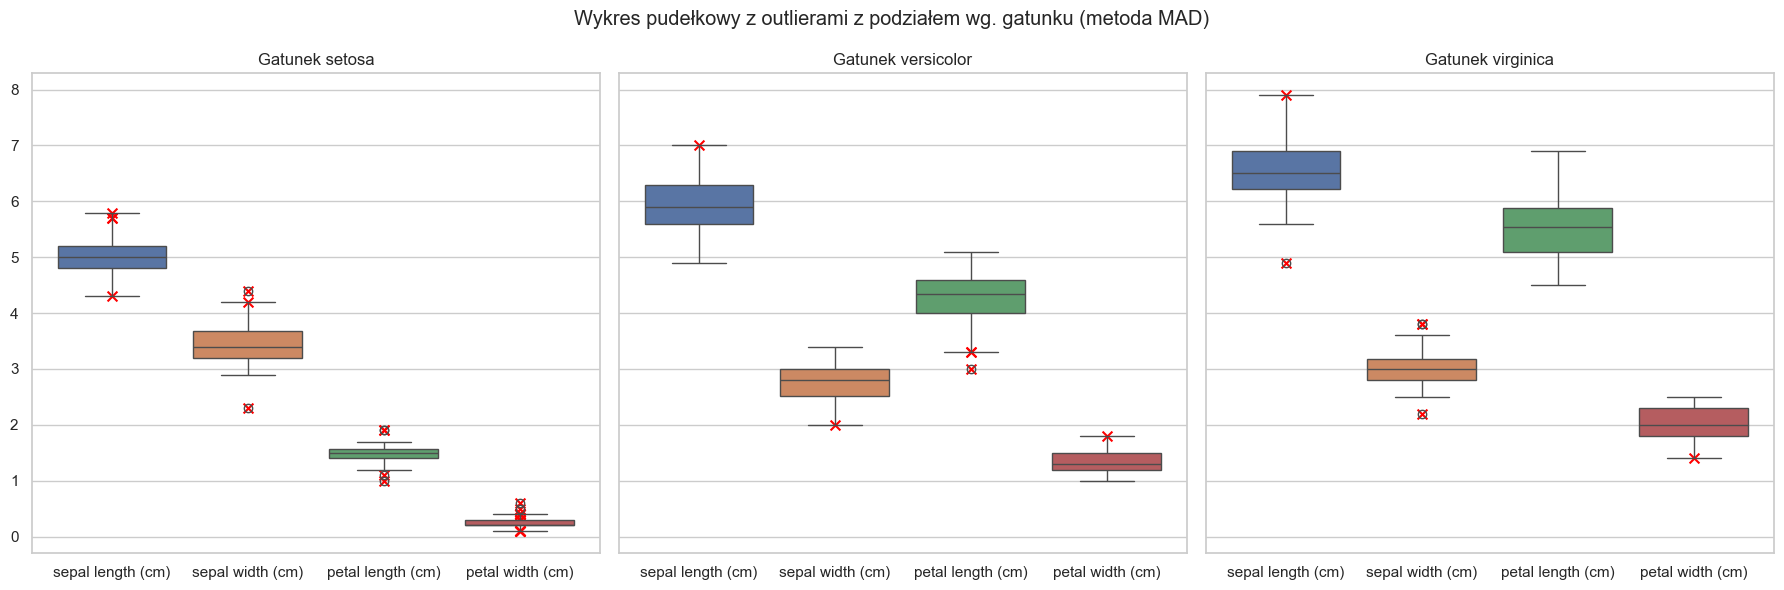

In [18]:
def detect_outliers_mad(data, column, threshold=3):
    median = data[column].median()
    mad = np.median(np.abs(data[column] - median))
    lower_bound = median - threshold * mad
    upper_bound = median + threshold * mad
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

outliers = {}
for species in iris_df['species'].unique():
    outliers[species] = {}
    for column in iris_df.columns[:-1]:
        outliers[species][column] = detect_outliers_mad(iris_df[iris_df['species'] == species], column)

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, species in enumerate(iris_df['species'].unique()):
    sns.boxplot(data=iris_df[iris_df['species'] == species].drop(columns=['species']), ax=axes[i])
    axes[i].set_title(f'Gatunek {species}')

    for j, column in enumerate(iris_df.columns[:-1]):
        outlier_points = outliers[species][column]
        axes[i].scatter([j]*len(outlier_points), outlier_points[column], color='red', s=50, marker='x')
fig.suptitle('Wykres pudełkowy z outlierami z podziałem wg. gatunku (metoda MAD)')

plt.tight_layout()
plt.show()

Wartości odstające są bardziej obecne w szerokości działki kielicha wśród wszystkich gatunków, z największą zmiennością obserwowaną u setosy. Długość działki kielicha i długość płatków są bardziej jednolite wśród wszystkich gatunków, natomiast szerokość płatków wykazuje umiarkowaną ilość wartości odstających, szczególnie wśród versicolor i virginica.

In [19]:
outliers_df_list = []
for species in iris_df['species'].unique():
    for column in iris_df.columns[:-1]:
        outliers_df_list.append(detect_outliers_mad(iris_df[iris_df['species'] == species], column))

outliers_df = pd.concat(outliers_df_list).drop_duplicates()
display(outliers_df)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
13,4.3,3.0,1.1,0.1,setosa
14,5.8,4.0,1.2,0.2,setosa
15,5.7,4.4,1.5,0.4,setosa
18,5.7,3.8,1.7,0.3,setosa
33,5.5,4.2,1.4,0.2,setosa
41,4.5,2.3,1.3,0.3,setosa
22,4.6,3.6,1.0,0.2,setosa
24,4.8,3.4,1.9,0.2,setosa
44,5.1,3.8,1.9,0.4,setosa
5,5.4,3.9,1.7,0.4,setosa


## Wybór algorytmów i modeli

### K-Nearest Neighbors (KNN)

KNN został wybrany do przetestowania ze względu na jego prostotę, intuicyjność oraz brak założeń o rozkładzie danych. Mimo że może być obliczeniowo kosztowny w fazie predykcji, jego elastyczność i łatwość implementacji sprawiają, że jest to dobry algorytm do wypróbowania w kontekście zadania, gdzie wymagana jest skuteczność powyżej 95%. Jego skuteczność może być zadowalająca, szczególnie na niewielkich zbiorach danych o umiarkowanej liczbie cech, takich jak zbiór Iris.

Najważniejsze informacje:
* **Złożoność czasowa:** Zależna od liczby próbek w zbiorze treningowym (O(n)).
* **Złożoność pamięciowa:** Przechowywanie wszystkich próbek w zbiorze treningowym.
* **Implementacja:** Bardzo prosta.

Uwaga: Może wymagać skalowania danych.

### Logistic Regression

Regresja logistyczna została wybrana do przetestowania ze względu na jej prostotę, szybkość, niskie wymagania pamięciowe i dobrą interpretowalność. Jest to stabilny algorytm, który jest mniej podatny na overfitting i może osiągnąć wysoką skuteczność przy odpowiednim preprocessing danych i regularyzacji. Choć ma swoje ograniczenia w przypadku nieliniowych zależności, jej prostota i efektywność sprawiają, że jest to solidna opcja do wypróbowania w kontekście zadania, gdzie wymagana jest skuteczność powyżej 95%.

Najważniejsze informacje:
* **Złożoność czasowa:** O(n) na epokę (n - liczba próbek).
* **Złożoność pamięciowa:** O(m) (m - liczba cech).
* **Implementacja:** Prosta, często daje dobre wyniki na zbiorach o niskiej liczbie cech.

### Support Vector Machines (SVM)

SVM został wybrany do przetestowania ze względu na jego potencjalną wysoką skuteczność, zdolność do radzenia sobie z nieliniowymi zależnościami oraz mechanizmy regularyzacji, które pomagają w zapobieganiu przetrenowaniu. Mimo że SVM może wymagać więcej zasobów obliczeniowych i odpowiedniego dostrojenia, jego potencjał do osiągnięcia wysokiej dokładności sprawia, że warto go rozważyć w kontekście zadania, gdzie wymagana jest skuteczność powyżej 95%.

Najważniejsze informacje:
* **Złożoność czasowa:** O(n^2) do O(n^3) na trening (n - liczba próbek).
* **Złożoność pamięciowa:** Zależna od liczby wsparcia (support vectors).
* **Implementacja:** Dostępne w wielu bibliotekach, wymaga wyboru odpowiedniego jądra (kernel).

Uwaga: Skalowanie danych często konieczne.

### Decision Trees

Drzewa decyzyjne zostały wybrane do przetestowania ze względu na ich łatwość interpretacji oraz zdolność do modelowania nieliniowych zależności. Chociaż mają tendencję do przetrenowania, można to kontrolować za pomocą technik przycinania i ograniczenia głębokości. Ich szybkość trenowania i predykcji, wraz z brakiem wymagań co do skalowania danych, sprawia, że są one dobrą opcją do wypróbowania w kontekście zadania, gdzie wymagana jest skuteczność powyżej 95%.

Najważniejsze informacje:
* **Złożoność czasowa:** O(n log n) na trening.
* **Złożoność pamięciowa:** Zależna od głębokości drzewa.
* **Implementacja:** Prosta, dobrze interpretuje dane.

Uwaga: Może wymagać przycinania (pruning) w celu uniknięcia nadmiernego dopasowania (overfittingu).

### Random Forest

Random Forest został wybrany do przetestowania ze względu na jego wysoką skuteczność, odporność na overfitting, zdolność do obsługi nieliniowych zależności oraz stabilność wyników. Pomimo wyższej złożoności obliczeniowej, jego zdolność do osiągania wysokiej dokładności klasyfikacji sprawia, że jest to wartościowy algorytm do rozważenia w kontekście zadania, gdzie wymagana jest skuteczność powyżej 95%.

Najważniejsze informacje:
* **Złożoność czasowa:** O(n log n) na drzewo.
* **Złożoność pamięciowa:** Zależna od liczby drzew i głębokości drzewa.
* **Implementacja:** Wymaga zrozumienia zasad zespołowych (ensemble methods).

Uwaga: Bardziej złożony niż pojedyncze drzewo decyzyjne, ale często osiąga lepsze wyniki.

### Naive Bayes

Naive Bayes został wybrany do przetestowania ze względu na jego niską złożoność czasową i pamięciową, prostotę implementacji, dobrą skuteczność przy małych zbiorach danych oraz odporność na szum w danych. Jego szybkie działanie i prostota sprawiają, że jest to wartościowy algorytm do rozważenia w kontekście zadania wymagającego skuteczności powyżej 95% przy minimalizacji złożoności czasowej, pamięciowej i implementacyjnej.

Najważniejsze informacje:
* **Złożoność czasowa:** O(n) na trening.
* **Złożoność pamięciowa:** O(m) (m - liczba cech).
* **Implementacja:** Bardzo prosta, często dobrze działa na małych zbiorach danych.

Uwaga: Zakłada niezależność cech, co może nie zawsze być prawdziwe.

## Eksperymenty

### Grid Search z walidacją krzyżową Stratified K-Fold

W tym teście używany jest GridSearchCV z walidacją krzyżową do automatycznego doboru najlepszych hiperparametrów dla każdego klasyfikatora. GridSearchCV przeprowadza walidację krzyżową z wykorzystaniem StratifiedKFold (n_splits=4) na zbiorze treningowym. Po znalezieniu najlepszych hiperparametrów, mierzony jest czas trenowania i predykcji za pomocą perf_counter i uśredniany na podstawie 100 powtórzeń. Czas predykcji oraz dokładność określane są na podstawie zbioru testowego.

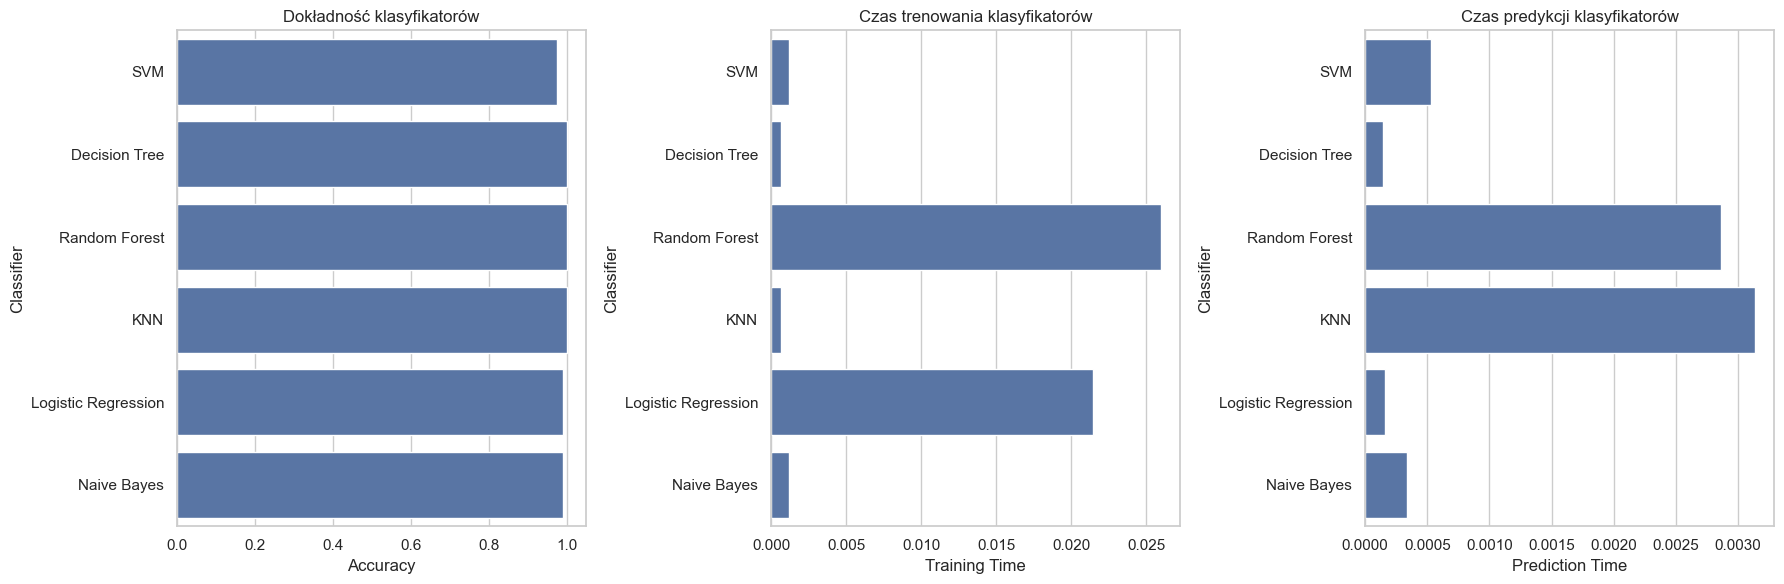

,Classifier,Accuracy,Training Time,Prediction Time,Params
0,SVM,0.975000,0.001163,0.000532,"{'C': 10, 'gamma': 0.01}"
1,Decision Tree,1.000000,0.000679,0.000146,{'max_depth': None}
2,Random Forest,1.000000,0.025954,0.002867,{'n_estimators': 10}
3,KNN,1.000000,0.000665,0.003135,{'n_neighbors': 5}
4,Logistic Regression,0.991667,0.021443,0.000158,{'C': 10}
5,Naive Bayes,0.991667,0.001214,0.000332,{}


In [20]:
iris = load_iris()
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classifiers = {
    'SVM': (SVC(), {'C': [0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1]}, True),
    'Decision Tree': (DecisionTreeClassifier(), {'max_depth': [None, 10, 20, 30, 40]}, False),
    'Random Forest': (RandomForestClassifier(), {'n_estimators': [10, 50, 100, 200]}, False),
    'KNN': (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7, 9]}, True),
    'Logistic Regression': (LogisticRegression(max_iter=200), {'C': [0.01, 0.1, 1, 10, 100]}, True),
    'Naive Bayes': (GaussianNB(), {}, False)
}

best_params = {}

skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

for name, (clf, params, needs_scaling) in classifiers.items():
    if needs_scaling:
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('clf', clf)
        ])
    else:
        pipeline = Pipeline([
            ('clf', clf)
        ])

    grid_search = GridSearchCV(pipeline, param_grid={'clf__' + k: v for k, v in params.items()}, cv=skf, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_params[name] = grid_search.best_params_

def measure_time(clf, params, X_train, y_train, X_test, y_test, needs_scaling):
    if needs_scaling:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    clf.set_params(**params)

    training_times = []
    prediction_times = []
    accuracies = []
    repeat = 100

    for train_index, val_index in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        for _ in range(repeat):
            start_time = perf_counter()
            clf.fit(X_train_fold, y_train_fold)
            training_times.append(perf_counter() - start_time)

        for _ in range(repeat):
            start_time = perf_counter()
            y_pred = clf.predict(X_test)
            prediction_times.append(perf_counter() - start_time)
            
        accuracies.append(accuracy_score(y_test, y_pred))

    training_time = np.mean(training_times)
    prediction_time = np.mean(prediction_times)
    accuracy = np.mean(accuracies)

    return training_time, prediction_time, accuracy

results = []

for name, (clf, _, needs_scaling) in classifiers.items():
    params = {k.split('__')[1]: v for k, v in best_params[name].items()}
    training_time, prediction_time, accuracy = measure_time(clf, params, X_train, y_train, X_test, y_test, needs_scaling)
    results.append({
        'Classifier': name,
        'Accuracy': accuracy,
        'Training Time': training_time,
        'Prediction Time': prediction_time,
        'Params': params
    })

results_df = pd.DataFrame(results)

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.barplot(x='Accuracy', y='Classifier', data=results_df)
plt.title('Dokładność klasyfikatorów')

plt.subplot(1, 3, 2)
sns.barplot(x='Training Time', y='Classifier', data=results_df)
plt.title('Czas trenowania klasyfikatorów')

plt.subplot(1, 3, 3)
sns.barplot(x='Prediction Time', y='Classifier', data=results_df)
plt.title('Czas predykcji klasyfikatorów')

plt.tight_layout()
plt.show()

display(results_df[['Classifier', 'Accuracy', 'Training Time', 'Prediction Time', 'Params']])

Wszystkie klasyfikatory przekroczyły próg 95%. Decision Tree utrzymał wysoką dokładność przy bardzo krótkich czasach treningu i predykcji.

### Ręczne strojenie hiperparametrów

W tym teście ręcznie dobierane są hiperparametry dla każdego klasyfikatora z użyciem siatki parametrów (ParameterGrid). Dane zostały podzielone na zestaw treningowy (60%), walidacyjny (20%) i testowy (20%). Każdy zestaw parametrów jest oceniany na podstawie dokładności na zbiorze walidacyjnym, a następnie na podstawie czasu trenowania i predykcji. Czas trenowania i predykcji jest mierzony za pomocą perf_counter, a wynik jest uśredniany na podstawie 100 powtórzeń.

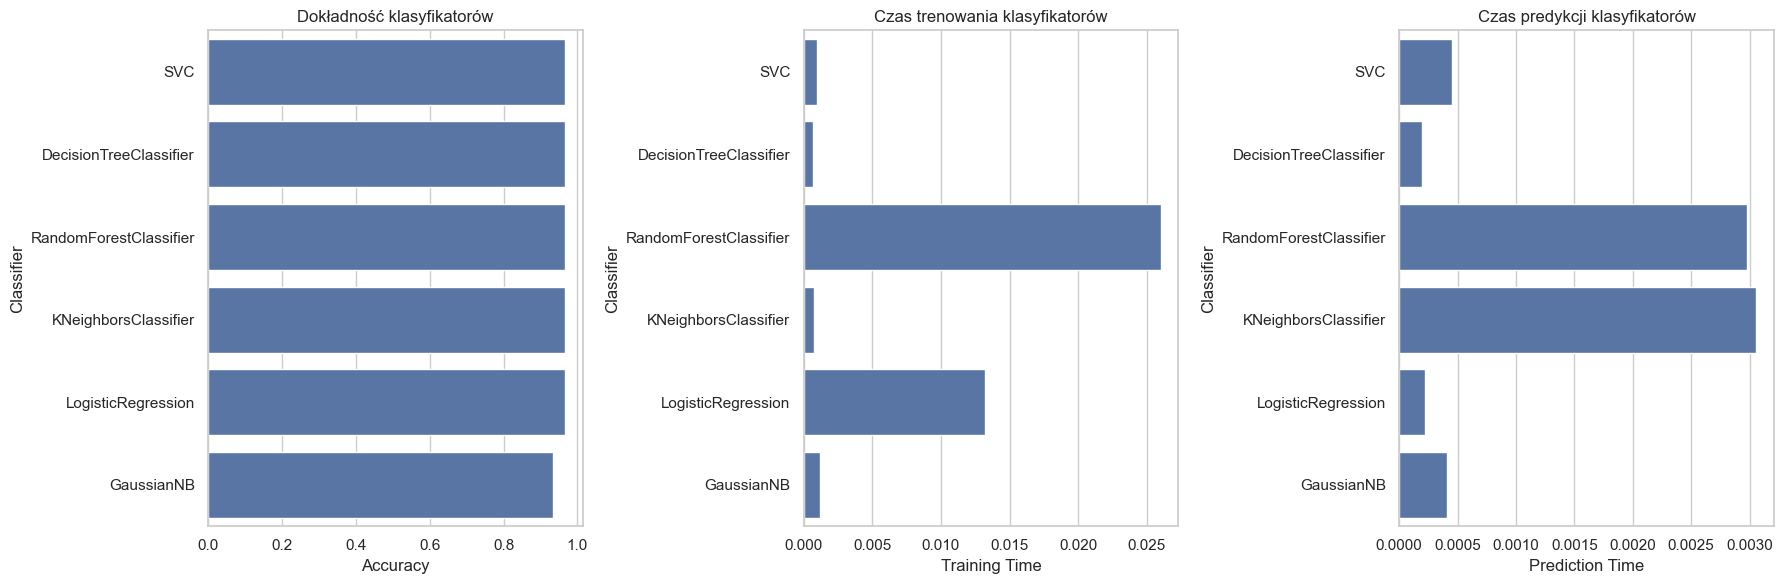

,Classifier,Accuracy,Training Time,Prediction Time,Params
0,SVC,0.966667,0.001002,0.000450,"{'C': 100, 'gamma': 0.01}"
1,DecisionTreeClassifier,0.966667,0.000675,0.000196,{'max_depth': 10}
2,RandomForestClassifier,0.966667,0.025994,0.002978,{'n_estimators': 10}
3,KNeighborsClassifier,0.966667,0.000742,0.003056,{'n_neighbors': 3}
4,LogisticRegression,0.966667,0.013213,0.000223,{'C': 1}
5,GaussianNB,0.933333,0.001172,0.000410,{}


In [21]:
iris = load_iris()
X = iris.data
y = iris.target

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

classifiers = {
    'SVM': (SVC(), {'C': [0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1]}, True),
    'Decision Tree': (DecisionTreeClassifier(), {'max_depth': [None, 10, 20, 30, 40]}, False),
    'Random Forest': (RandomForestClassifier(), {'n_estimators': [10, 50, 100, 200]}, False),
    'KNN': (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7, 9]}, True),
    'Logistic Regression': (LogisticRegression(max_iter=200), {'C': [0.01, 0.1, 1, 10, 100]}, True),
    'Naive Bayes': (GaussianNB(), {}, False)
}

def test_classifier_params(clf, params, X_train, y_train, X_val, y_val, X_test, y_test, needs_scaling):
    best_result = None
    potential_params = []

    if needs_scaling:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        X_test = scaler.transform(X_test)

    for param_combination in ParameterGrid(params):
        clf.set_params(**param_combination)
        clf.fit(X_train, y_train)
        val_accuracy = accuracy_score(y_val, clf.predict(X_val))

        if val_accuracy > 0.95:
            potential_params.append(param_combination)

    for param_combination in potential_params:
        clf.set_params(**param_combination)
        training_times = []
        prediction_times = []
        repeat = 100

        for _ in range(repeat):
            start_time = perf_counter()
            clf.fit(X_train, y_train)
            training_times.append(perf_counter() - start_time)

            start_time = perf_counter()
            y_pred = clf.predict(X_test)
            prediction_times.append(perf_counter() - start_time)

        training_time = np.mean(training_times)
        prediction_time = np.mean(prediction_times)
        test_accuracy = accuracy_score(y_test, y_pred)

        if test_accuracy > 0.95:
            result = {
                'Classifier': clf.__class__.__name__,
                'Params': param_combination,
                'Accuracy': test_accuracy,
                'Training Time': training_time,
                'Prediction Time': prediction_time
            }

            if best_result is None or (training_time + prediction_time) < (best_result['Training Time'] + best_result['Prediction Time']):
                best_result = result

        if best_result is None or ((training_time + prediction_time) < (best_result['Training Time'] + best_result['Prediction Time']
                                                                        and test_accuracy > best_result['Accuracy'])):
            result = {
                'Classifier': clf.__class__.__name__,
                'Params': param_combination,
                'Accuracy': test_accuracy,
                'Training Time': training_time,
                'Prediction Time': prediction_time
            }

            best_result = result

    return best_result

results = []

for name, (clf, params, needs_scaling) in classifiers.items():
    result = test_classifier_params(clf, params, X_train, y_train, X_val, y_val, X_test, y_test, needs_scaling)
    if result:
        results.append(result)

results_df = pd.DataFrame(results)

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.barplot(x='Accuracy', y='Classifier', data=results_df)
plt.title('Dokładność klasyfikatorów')

plt.subplot(1, 3, 2)
sns.barplot(x='Training Time', y='Classifier', data=results_df)
plt.title('Czas trenowania klasyfikatorów')

plt.subplot(1, 3, 3)
sns.barplot(x='Prediction Time', y='Classifier', data=results_df)
plt.title('Czas predykcji klasyfikatorów')

plt.tight_layout()
plt.show()

display(results_df[['Classifier', 'Accuracy', 'Training Time', 'Prediction Time', 'Params']])


Wszystkie klasyfikatory oprócz Naive Bayes przekroczyły próg dokładności 95%. Las losowy miał znacznie dłuższy czas treningu i predykcji od pozostałych. KNN osiągnął również wysoką dokładność, ale z wyraźnie dłuższym czasem predykcji.

### Ręczne strojenie hiperparametrów z walidacją krzyżową Stratified K-Fold

W tym teście ręcznie dobierane są hiperparametry dla każdego klasyfikatora z użyciem siatki parametrów (ParameterGrid). Każdy zestaw parametrów jest oceniany przy użyciu walidacji krzyżowej (StratifiedKFold z n_splits=5).
W każdym foldzie mierzony jest czas trenowania i predykcji za pomocą perf_counter i wynik jest uśredniany na podstawie 100 powtórzeń.
Średnie wartości dokładności, czasu trenowania i predykcji są obliczane dla każdego zestawu parametrów.

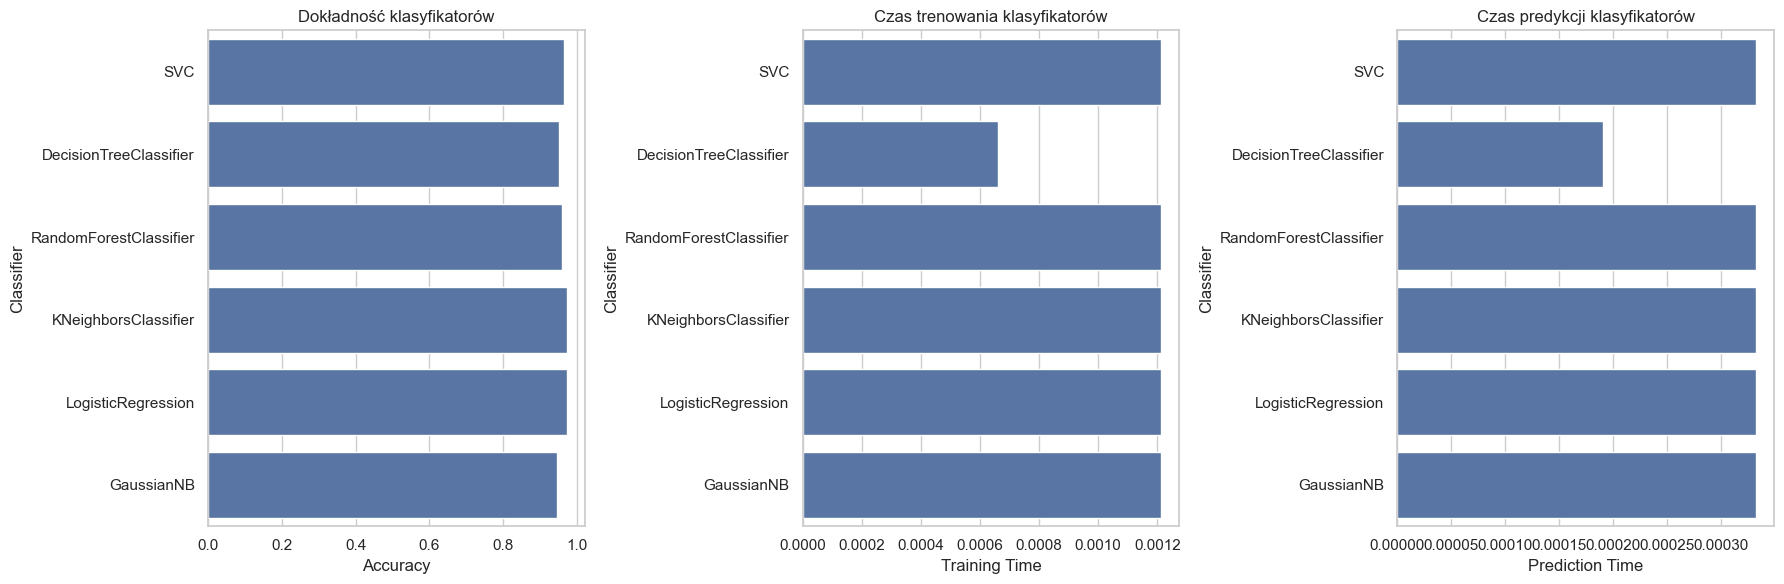

,Classifier,Accuracy,Training Time,Prediction Time,Params
0,SVC,0.966667,0.001214,0.000332,"{'C': 10, 'gamma': 0.1}"
1,DecisionTreeClassifier,0.953333,0.000661,0.000191,{'max_depth': 20}
2,RandomForestClassifier,0.960000,0.001214,0.000332,{'n_estimators': 50}
3,KNeighborsClassifier,0.973333,0.001214,0.000332,{'n_neighbors': 5}
4,LogisticRegression,0.973333,0.001214,0.000332,{'C': 10}
5,GaussianNB,0.946667,0.001214,0.000332,{}


In [22]:
iris = load_iris()
X = iris.data
y = iris.target

classifiers = {
    'SVM': (SVC(), {'C': [0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1]}, True),
    'Decision Tree': (DecisionTreeClassifier(), {'max_depth': [None, 10, 20, 30, 40]}, False),
    'Random Forest': (RandomForestClassifier(), {'n_estimators': [10, 50, 100, 200]}, False),
    'KNN': (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7, 9]}, True),
    'Logistic Regression': (LogisticRegression(max_iter=200), {'C': [0.01, 0.1, 1, 10, 100]}, True),
    'Naive Bayes': (GaussianNB(), {}, False)
}

def test_classifier_params(clf, params, X, y, needs_scaling, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    best_result = None

    for param_combination in ParameterGrid(params):
        training_times = []
        prediction_times = []
        accuracies = []

        for train_index, test_index in skf.split(X, y):
            X_train_fold, X_test_fold = X[train_index], X[test_index]
            y_train_fold, y_test_fold = y[train_index], y[test_index]

            if needs_scaling:
                scaler = StandardScaler()
                X_train_fold = scaler.fit_transform(X_train_fold)
                X_test_fold = scaler.transform(X_test_fold)

            clf.set_params(**param_combination)

            repeat = 100

            for _ in range(repeat):
                start_time = perf_counter()
                clf.fit(X_train_fold, y_train_fold)
                training_times.append(perf_counter() - start_time)

                start_time = perf_counter()
                y_pred_fold = clf.predict(X_test_fold)
                prediction_times.append(perf_counter() - start_time)

            accuracies.append(accuracy_score(y_test_fold, y_pred_fold))

        avg_training_time = np.mean(training_times)
        avg_prediction_time = np.mean(prediction_times)
        avg_accuracy = np.mean(accuracies)

        if avg_accuracy > 0.95:
            result = {
                'Classifier': clf.__class__.__name__,
                'Params': param_combination,
                'Accuracy': avg_accuracy,
                'Training Time': avg_training_time,
                'Prediction Time': avg_prediction_time
            }
            if best_result is None or (avg_training_time + avg_prediction_time) < (best_result['Training Time'] + best_result['Prediction Time']):
                best_result = result

        if best_result is None or ((training_time + prediction_time) < (best_result['Training Time'] + best_result['Prediction Time']
                                                                        and avg_accuracy > best_result['Accuracy'])):
            result = {
                'Classifier': clf.__class__.__name__,
                'Params': param_combination,
                'Accuracy': avg_accuracy,
                'Training Time': training_time,
                'Prediction Time': prediction_time
            }

            best_result = result

    return best_result

results = []

for name, (clf, params, needs_scaling) in classifiers.items():
    result = test_classifier_params(clf, params, X, y, needs_scaling)
    if result:
        results.append(result)

results_df = pd.DataFrame(results)

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.barplot(x='Accuracy', y='Classifier', data=results_df)
plt.title('Dokładność klasyfikatorów')

plt.subplot(1, 3, 2)
sns.barplot(x='Training Time', y='Classifier', data=results_df)
plt.title('Czas trenowania klasyfikatorów')

plt.subplot(1, 3, 3)
sns.barplot(x='Prediction Time', y='Classifier', data=results_df)
plt.title('Czas predykcji klasyfikatorów')

plt.tight_layout()
plt.show()

display(results_df[['Classifier', 'Accuracy', 'Training Time', 'Prediction Time', 'Params']])


Najwyższą dokładność osiągnęły KNN i Logistic Regression (97.33%), ale wszystkie klasyfikatory poza Naive Bayes osiągnęły dokładność powyżej 95%. Czas treningu i predykcji był najkrótszy dla Decision Tree.

## Wnioski

Wszystkie trzy testy wykazały, że kilka klasyfikatorów osiąga dokładność powyżej 95%. Drzewo decyzyjne i las losowy konsekwentnie osiągały wysoką dokładność, ale las losowy miał wyraźnie dłuższy czas treningu i testowania. SVM, Logistic Regression i KNN osiągnęły bardzo dobre wyniki pod względem dokładności, jednak ich czasy trenowania i testowania były umiarkowane. Naive Bayes, mimo że jest najprostszym klasyfikatorem pod względem złożoności implementacyjnej i czasów, nie zawsze osiągał wymagane 95% dokładności.

Finalnym klasyfikatorem wybranym do klasyfikacji zbioru danych Iris jest Decision Tree. W każdym teście klasyfikator spełniał wymagania dotyczące minimalnej złożoności czasowej oraz skuteczności powyżej 95%. Decision Tree zapewnia łatwość implementacji oraz interpretacji wyników, a także nie wymaga dużej ilości pamięci, co czyni je optymalnym wyborem dla tego zadania.

## Przykładowa implementacja

Dokładność klasyfikatora drzewa decyzyjnego: 1.00



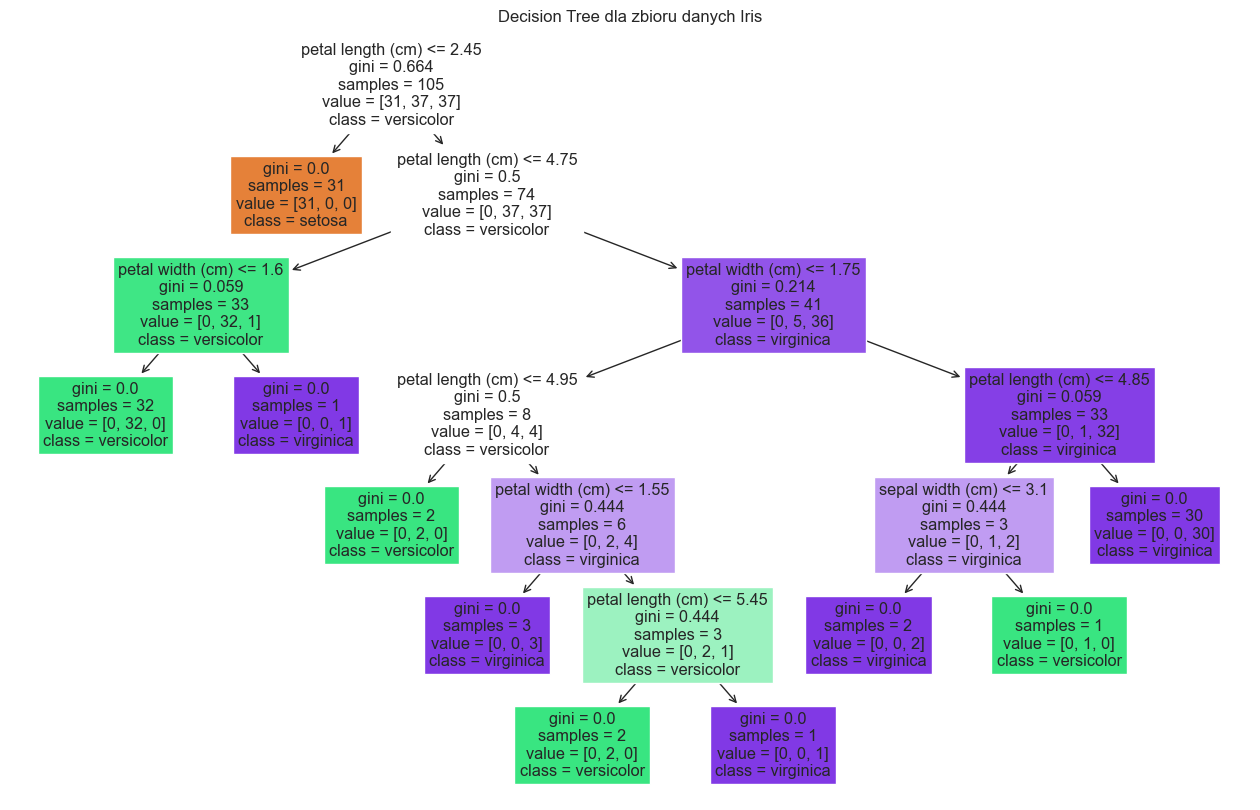

In [23]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Załadowanie danych
iris = load_iris()
X, y = iris.data, iris.target

# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Inicjalizacja i trenowanie modelu
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predykcja i ocena skuteczności
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Dokładność klasyfikatora drzewa decyzyjnego: {accuracy:.2f}")
print()

# Wizualizacja drzewa decyzyjnego
from sklearn import tree

plt.figure(figsize=(16,10))
tree.plot_tree(clf, filled=True, feature_names=iris.feature_names, class_names=iris.target_names)
plt.title("Decision Tree dla zbioru danych Iris")
plt.show()